# Illustrating different covariance functions in Gaussian Process Regression
Part of CSME2, WS21/22, Exercise Session 13

Based on a notebook by Dominik Baumann from CSME2, WS20/21. Last edit 01/02/22.

In [10]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
import numpy as np
import matplotlib.pyplot as plt

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\stann\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['mean', 'gamma', 'var']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


We define two datasets: one with a discontinuity, the other one following a sine wave.

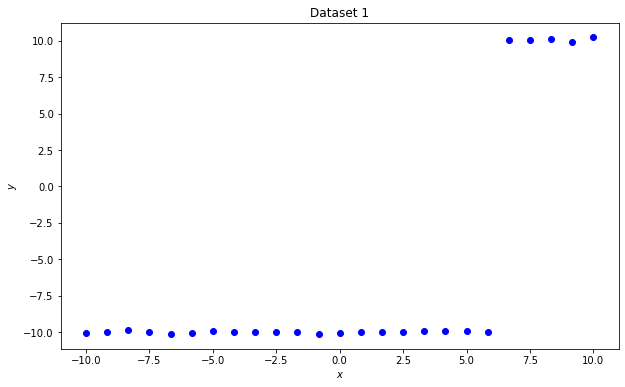

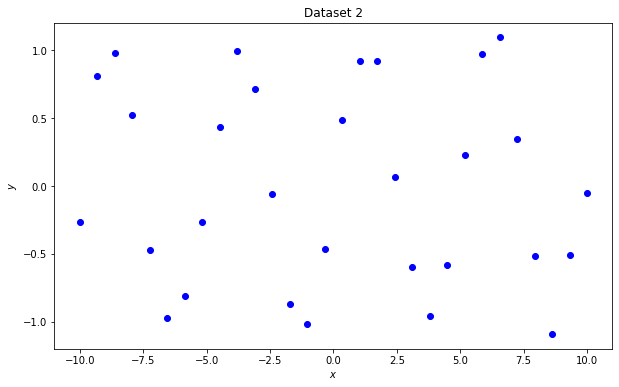

In [18]:
# Dataset 1
x1 = np.linspace(-10, 10, 25)
y1 = np.array([-10.09512806,  -9.97009432,  -9.89113276,  -9.96491011, -10.1260379,
 -10.03663368,  -9.95279491, -10.029003,    -9.98736298,  -9.9688468,
  -9.99185142, -10.13414181, -10.05712536, -10.00938772,  -9.98877184,
  -9.99983221,  -9.90398335,  -9.9279341,   -9.91520247, -10.02093321,
  10.04359211,  10.01884211,  10.10494905,   9.9100712,   10.22267105])

# Dataset 2
x2 = np.linspace(-10, 10, 30)
y2 = np.array([-0.26219616,  0.8075561,   0.9827549,   0.5230104,  -0.47350645, -0.97534683,
 -0.80964853, -0.26794227,  0.43849501,  0.99881357,  0.71416006, -0.06055552,
 -0.87116864, -1.0203934,  -0.46327039,  0.48870093,  0.92404831,  0.92335769,
  0.06377571, -0.59929116, -0.95772374, -0.57898516,  0.23164953,  0.97236024,
  1.09524087,  0.34672,    -0.51475776, -1.09076993, -0.51173754, -0.04930549,])

# Test input vectors
xs1 = np.linspace(-15, 15, 100)
xs2 = np.linspace(-15, 15, 100)

# Measurement noise
noise_var = 1e-4

plt.title('Dataset 1')
plt.plot(x1, y1, 'bo')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

plt.title('Dataset 2')
plt.plot(x2, y2, 'bo')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

We define the squared exponential kernel, setting $\sigma = 1$ and $l = \sqrt{2}$

In [12]:
sigma_f = 1
l = np.sqrt(2)

def k_se(a,b):
    return sigma_f**2*np.exp (-1/(2*l**2)*np.abs(a[:,np.newaxis]-b[:,np.newaxis ].T)**2)

Computing the posterior distribution (more precisely, the posterior mean and covariance that uniquely describes the posterior distribution).

In [13]:
def get_posterior(k, x, xs, y):
    K = k(x, x)
    Ks = k(x, xs)
    Kss = k(xs, xs)
    mu_post = (Ks.T@np.linalg.inv(K + noise_var*np.eye(x.shape[0])))@y
    K_post = Kss - Ks.T@np.linalg.inv(K + noise_var*np.eye(x.shape[0]))@Ks
    return mu_post, K_post

We plot the mean of the predictive distribution along with its uncertainty for both datasets. It can be seen that in both cases, the SE kernel does not yield the desired performance. While the GP manages to fit the data rather well, there is a large overshoot when trying to extrapolate.

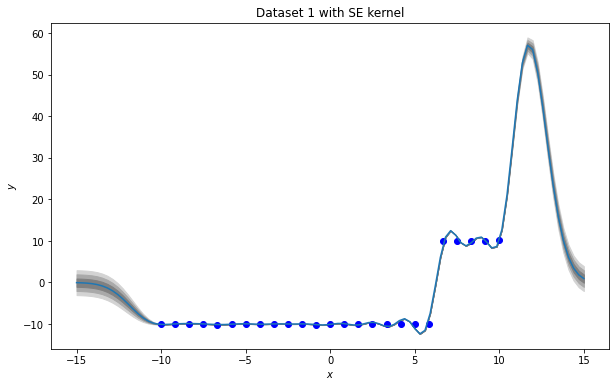

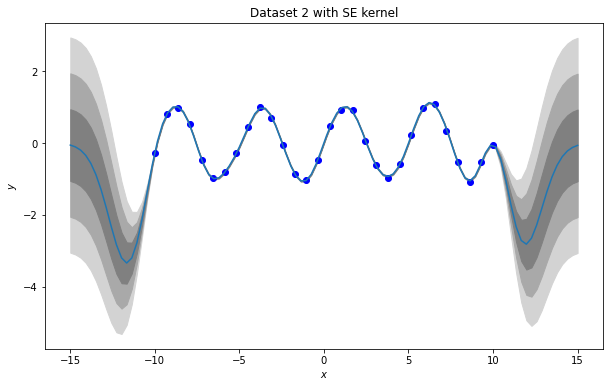

In [14]:
# Plot SE kernel
plt.title('Dataset 1 with SE kernel')
mean, var = get_posterior(k_se, x1, xs1, y1)
plt.plot(x1, y1, 'bo')
plt.plot(xs1, mean)
plt.fill_between (xs1, mean + 3*np.sqrt(np.diag(var)), mean - 3*np.sqrt(np.diag(var)), color='lightgray')
plt.fill_between (xs1, mean + 2*np.sqrt(np.diag(var)), mean - 2*np.sqrt(np.diag(var)), color='darkgray')
plt.fill_between (xs1, mean + 1*np.sqrt(np.diag(var)), mean - 1*np.sqrt(np.diag(var)), color='gray')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

plt.title('Dataset 2 with SE kernel')
mean, var = get_posterior(k_se, x2, xs2, y2)
plt.plot(x2, y2, 'bo')
plt.plot(xs2, mean)
plt.fill_between (xs2, mean + 3*np.sqrt(np.diag(var)), mean - 3*np.sqrt(np.diag(var)), color='lightgray')
plt.fill_between (xs2, mean + 2*np.sqrt(np.diag(var)), mean - 2*np.sqrt(np.diag(var)), color='darkgray')
plt.fill_between (xs2, mean + 1*np.sqrt(np.diag(var)), mean - 1*np.sqrt(np.diag(var)), color='gray')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

Since the SE kernel did not work the way we wanted it to, we now define a Matern 3/2 kernel for the first data set and a combination of periodic and SE kernel for the second dataset. For both, we again choose a length scale of $l=\sqrt{2}$ and for the periodic kernel, we use $\sigma=1$ as for the SE kernel and $p=5$.

In [15]:
from scipy.special import gamma, kv
l = np.sqrt(2)
v = 3/2 # Typically either choose 5/2 or 3/2
def k_mat(a, b):
    sqdist = np.abs(a[:,np.newaxis]-b[:,np.newaxis ].T).astype(float)
    sqdist[sqdist == 0] = 1e-8
    part1 = 2 ** (1 - v) / gamma(v)
    part2 = (np.sqrt(2 * v) * sqdist / l) ** v
    part3 = kv(v, np.sqrt(2 * v) * sqdist / l)
    return part1 * part2 * part3

In [16]:
sigma = 1
l = np.sqrt(2)
p = 5
def k_per(a, b):
    sqdist = np.abs(a[:,np.newaxis]-b[:,np.newaxis ].T).astype(float)
    per = sigma**2*np.exp(-(2*np.sin(np.pi*sqdist/p)**2)/l**2)
    return per*k_se(a,b)

Now, both GPs are able to fit the date *and* do not diverge.

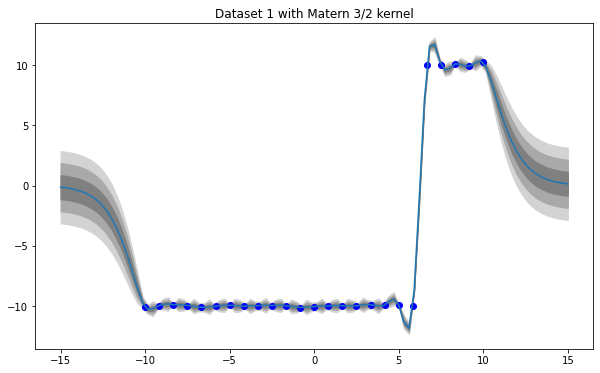

In [17]:
# Plot Matern kernel
mean, var = get_posterior(k_mat, x1, xs1, y1)
plt.title('Dataset 1 with Matern 3/2 kernel')
plt.plot(x1, y1, 'bo')
plt.plot(xs1, mean)
plt.fill_between (xs1, mean + 3*np.sqrt(np.diag(var)), mean - 3*np.sqrt(np.diag(var)), color='lightgray')
plt.fill_between (xs1, mean + 2*np.sqrt(np.diag(var)), mean - 2*np.sqrt(np.diag(var)), color='darkgray')
plt.fill_between (xs1, mean + 1*np.sqrt(np.diag(var)), mean - 1*np.sqrt(np.diag(var)), color='gray')
plt.show()

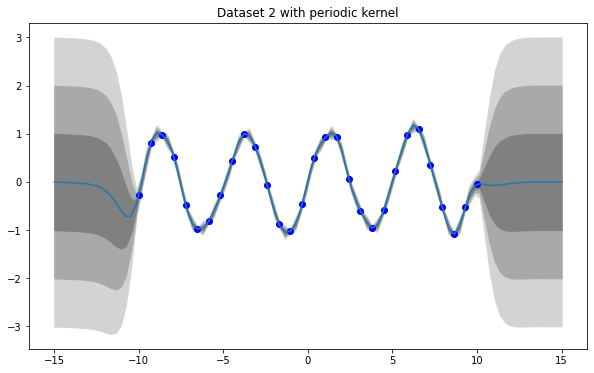

In [9]:
# Plot periodic kernel
mean, var = get_posterior(k_per, x2, xs2, y2)
plt.title('Dataset 2 with periodic kernel')
plt.plot(x2, y2, 'bo')
plt.plot(xs2, mean)
plt.fill_between (xs2, mean + 3*np.sqrt(np.diag(var)), mean - 3*np.sqrt(np.diag(var)), color='lightgray')
plt.fill_between (xs2, mean + 2*np.sqrt(np.diag(var)), mean - 2*np.sqrt(np.diag(var)), color='darkgray')
plt.fill_between (xs2, mean + 1*np.sqrt(np.diag(var)), mean - 1*np.sqrt(np.diag(var)), color='gray')
plt.show()